In [ ]:
!pip install transformers
!pip install --upgrade spacy

In [2]:
import pandas as pd
import spacy
from keras.callbacks import EarlyStopping, ModelCheckpoint
from numpy import savetxt, loadtxt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np
import gensim
import keras
from keras.preprocessing import text, sequence
from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Embedding, LSTM, Dropout, Bidirectional, Conv1D, GlobalMaxPool1D
import tensorflow as tf
import gensim.downloader
from transformers import TFBertModel, BertTokenizer
import torch
from tokenizers import BertWordPieceTokenizer

path = '/content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/'

In [20]:
# import original data files
data_1 = pd.read_json(path+"Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json(path+"Sarcasm_Headlines_Dataset_v2.json", lines=True)

data_all = pd.concat([data_1, data_2], axis=0, ignore_index=True)
data_all = data_all.drop_duplicates(subset=['headline'])
data_all = data_all.drop(['article_link'], axis=1)
data_all = data_all.sample(frac=1, random_state=0)

len(data_all)  # 28503
sum(data_all['is_sarcastic'] == 0) / len(data_all)  # 0.5245

0.5245412763568748

In [4]:
data_2.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [ ]:
!python -m spacy download en_core_web_lg

In [21]:
# tokenize the data!
nlp = spacy.load('en_core_web_lg')

def preprocess(text):
    doc = nlp(text)
    res = []
    for token in doc:
        if token.is_stop != True and token.is_alpha == True:
            res.append(token.text.lower())
    return " ".join(res)

data_all['headline_before'] = data_all['headline']
data_all['headline'] = data_all['headline_before'].apply(preprocess)

In [22]:
empty_headlines_idx = np.where(data_all['headline'].apply(lambda x: x == ''))
data_all.iloc[empty_headlines_idx]
#                     headline  is_sarcastic
# 9295     i was, but now i am             0
# 19626      what's in a name?             0
# 25158  who were you on 9/11?             0
# 26311         you are enough             0
data_tokenized = data_all.drop_duplicates(subset=['headline'])
data_tokenized = data_all[data_all.headline != '']
# save tokenized data
data_tokenized.to_json(r'Sarcasm_Headlines_Dataset_tokenized.json', orient='records')
len(data_tokenized)  # 28464

28499

In [67]:
# read tokenized data
data_tokenized = pd.read_json(path+"Sarcasm_Headlines_Dataset_tokenized.json")

In [68]:
data_tokenized[:10]

,headline,is_sarcastic
0,trucking industry honors methamphetamines,1
1,scientists receive million grant melt stuff,1
2,listen area boss gets,1
3,pope francis finds self hell taking wrong turn...,1
4,report finds poor hit hardest,1
5,impatient nation demands supreme court gay stuff,1
6,lessons learned diane keaton new book,0
7,brazilian artists pay tribute olympic refugee ...,0
8,hiring employee know hurt business,0
9,watch dirt bikers bit close nature,0


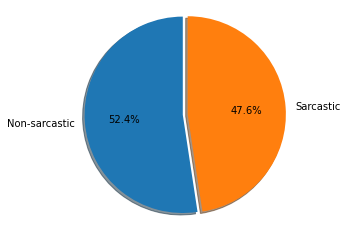

In [35]:
# visualize the data
fig, ax = plt.subplots()
ax.pie([sum(data_tokenized['is_sarcastic'] == 0), sum(data_tokenized['is_sarcastic'] == 1)],
        explode=(0,0.05), labels=["Non-sarcastic","Sarcastic"], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')
plt.show()
fig.savefig(path+"class distribution.png")

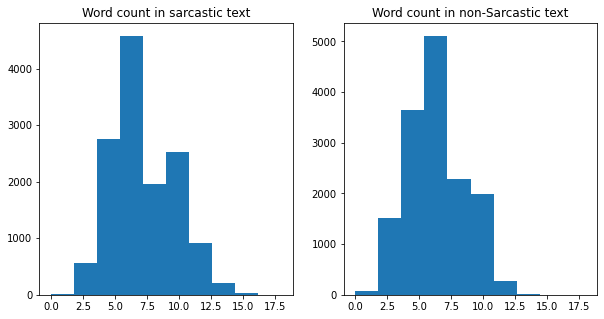

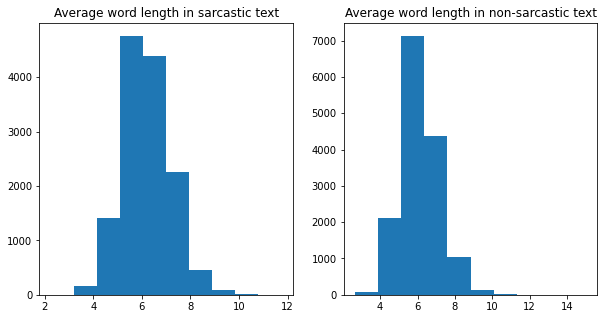

In [36]:
# visualize the data
sum(data_tokenized['is_sarcastic'] == 0) / len(data_tokenized)  # 0.5239
data_headline_sar = data_tokenized[data_tokenized['is_sarcastic'] == 1]['headline']
data_headline_non_sar = data_tokenized[data_tokenized['is_sarcastic'] == 0]['headline']
# word counts distribution in each class
text_len_sar = data_headline_sar.map(lambda x: len(x.split()))
text_len_non_sar = data_headline_non_sar.map(lambda x: len(x.split()))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Word count in sarcastic text')
ax[0].hist(text_len_sar, range=(0, 18))  # exclude 6
ax[1].set_title('Word count in non-Sarcastic text')
ax[1].hist(text_len_non_sar, range=(0, 18))  # exclude 1
plt.show()
fig.savefig(path+"Words in text.png")

# average word length of each text distribution in each class
word_len_sar = data_headline_sar.map(lambda x: np.mean([len(i) for i in x.split()]))
word_len_non_sar = data_headline_non_sar.map(lambda x: np.mean([len(i) for i in x.split()]))
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Average word length in sarcastic text')
ax[0].hist(word_len_sar)
ax[1].set_title('Average word length in non-sarcastic text')
ax[1].hist(word_len_non_sar)
plt.show()
fig.savefig(path+"Average word length in text.png")

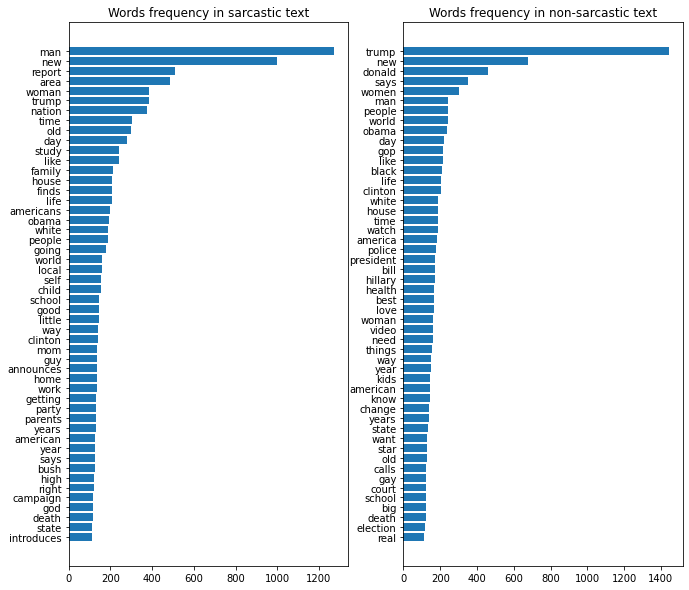

In [37]:
# visualize the data
words_sar = data_headline_sar.str.split(expand=True).unstack().value_counts(ascending=True)
words_nonsar = data_headline_non_sar.str.split(expand=True).unstack().value_counts(ascending=True)
fig, ax = plt.subplots(1, 2, figsize=(11, 10))
ax[0].set_title('Words frequency in sarcastic text')
ax[0].barh(range(50), words_sar.values[-50:], tick_label=words_sar.keys()[-50:])
ax[1].set_title('Words frequency in non-sarcastic text')
ax[1].barh(range(50), words_nonsar.values[-50:], tick_label=words_nonsar.keys()[-50:])
plt.show()
fig.savefig(path+"Words frequency in text.png")

In [69]:
# split data into training, validation, test dataset
data_trainval, data_test = train_test_split(data_tokenized, test_size=0.15, random_state=0)
data_train, data_val = train_test_split(data_trainval, test_size=0.2, random_state=0)

print(len(data_train))  # 19355
print(len(data_val))  # 4839
print(len(data_test))  # 4270


19355
4839
4270


              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2241
           1       0.78      0.79      0.78      2029

    accuracy                           0.79      4270
   macro avg       0.79      0.79      0.79      4270
weighted avg       0.79      0.79      0.79      4270



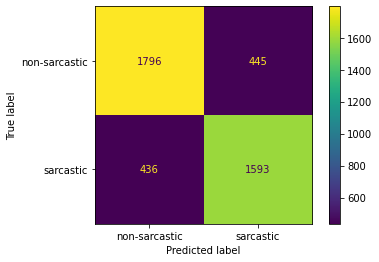

The best model is found using binary = True, ngram_range = (1, 2), alpha = 1 with average accuracy of 0.799.


In [5]:
# baselines
# naive bayes classifier - 79%
pipe = Pipeline([('vectorizer', CountVectorizer()), ('MNB', MultinomialNB())])
pipe.fit(data_train['headline'], data_train['is_sarcastic'])
nb_pred = pipe.predict(data_test['headline'])
print(classification_report(data_test['is_sarcastic'], nb_pred))
# show confusion matrix
cm = confusion_matrix(data_test['is_sarcastic'], nb_pred, labels=[0, 1])
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["non-sarcastic", "sarcastic"])
display.plot()
plt.show()

# CV
parameters = {'vectorizer__binary': [False, True],
              'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
              'MNB__alpha': [5, 2, 1]}
clf = GridSearchCV(pipe, parameters, cv=5)
clf.fit(data_trainval['headline'], data_trainval['is_sarcastic'])
print(f"The best model is found using binary = {clf.best_params_['vectorizer__binary']}, "
      f"ngram_range = {clf.best_params_['vectorizer__ngram_range']}, "
      f"alpha = {clf.best_params_['MNB__alpha']} with average accuracy of {round(clf.best_score_, 3)}.")

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      2241
           1       0.80      0.75      0.77      2029

    accuracy                           0.79      4270
   macro avg       0.79      0.79      0.79      4270
weighted avg       0.79      0.79      0.79      4270



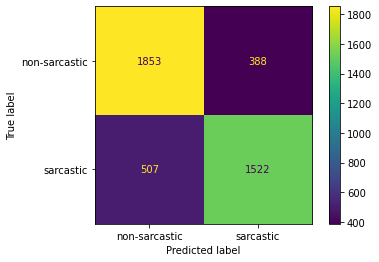

In [6]:
# Try TfidfVectorizer
# naive bayes classifier - 79%
pipe = Pipeline([('vectorizer', TfidfVectorizer()), ('MNB', MultinomialNB())])
pipe.fit(data_train['headline'], data_train['is_sarcastic'])
nb_pred = pipe.predict(data_test['headline'])
print(classification_report(data_test['is_sarcastic'], nb_pred))
# show confusion matrix
cm = confusion_matrix(data_test['is_sarcastic'], nb_pred, labels=[0, 1])
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["non-sarcastic", "sarcastic"])
display.plot()
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      2241
           1       0.79      0.79      0.79      2029

    accuracy                           0.80      4270
   macro avg       0.80      0.80      0.80      4270
weighted avg       0.80      0.80      0.80      4270



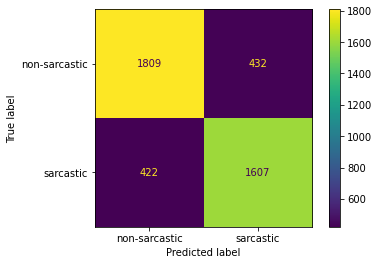

In [45]:
# with count vectorizer
# After CV - 0.80
pipe = Pipeline([('vectorizer', CountVectorizer(binary=True, ngram_range=(1, 2))),
                 ('MNB', MultinomialNB())])
pipe.fit(data_train['headline'], data_train['is_sarcastic'])
nb_pred = pipe.predict(data_test['headline'])
print(classification_report(data_test['is_sarcastic'], nb_pred))
# show confusion matrix
cm = confusion_matrix(data_test['is_sarcastic'], nb_pred, labels=[0, 1])
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["non-sarcastic", "sarcastic"])
display.plot()
plt.show()
display.im_.figure.savefig(path+"naive bayes cm.png")

In [70]:
# Methodology
# LSTM
tokenizer = text.Tokenizer(num_words=35000)
tokenizer.fit_on_texts(data_train.headline)  # only train
tokenized_train = tokenizer.texts_to_sequences(data_train.headline)
x_train_seq = sequence.pad_sequences(tokenized_train, maxlen=20)
tokenized_val = tokenizer.texts_to_sequences(data_val.headline)  # only val
x_val_seq = sequence.pad_sequences(tokenized_val, maxlen=20)
tokenized_test = tokenizer.texts_to_sequences(data_test.headline)  # only test
x_test_seq = sequence.pad_sequences(tokenized_test, maxlen=20)

size_of_vocabulary = min(35000, len(tokenizer.word_index) + 1)  # 21736   +1 for UNKNOWN

In [ ]:
# create wordembedding matrix
# # Glove glove.6B.200d
# # load glove word vectors
# embeddings_index = dict()
# f = open('glove.6B/glove.6B.200d.txt')
# for line in f:
#     values = line.split()
#     embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
# f.close()
# print('Loaded %s word vectors from GloVe.' % len(embeddings_index))  # 400,000
# # create a weight matrix for words in training data
embedding_matrix = np.zeros((size_of_vocabulary, 200))  # 21736x200
# for word, i in tokenizer.word_index.items():
#     if i >= 35000:
#         continue
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[i] = embedding_vector
# # glove glove.6B.200d end

# gensim - glove-twitter-200
# print(list(gensim.downloader.info()['models'].keys()))
glove_vectors = gensim.downloader.load('glove-twitter-200')
print('Loaded %s word vectors from GloVe.' % len(glove_vectors))  # 1,193,514
# create a weight matrix for words in training data
for word, i in tokenizer.word_index.items():
    if i >= 35000:
        continue
    if word in glove_vectors.key_to_index:
        embedding_matrix[i] = glove_vectors[word]
# gensim - glove-twitter-200 end

# save embedding_matrix to csv file
savetxt(path+'embedding_matrix_glovetwitter200.csv', embedding_matrix, delimiter=',')

In [37]:
# load array
# embedding_matrix = loadtxt('embedding_matrix_glove6B200d.csv', delimiter=',', dtype='float32')
embedding_matrix = loadtxt(path+'embedding_matrix_glovetwitter200.csv', delimiter=',', dtype='float32')

In [45]:
# function to plot model training process
def plot_modelfit_process(model_history, title):
  n = len(model_history.history['acc'])
  fig, ax = plt.subplots(2, 1, figsize=(8, 8))
  ax[0].set_title('Accuracy')
  ax[0].plot(model_history.history['acc'])
  ax[0].plot(model_history.history['val_acc'])
  ax[0].axvline(x=np.where(model_history.history['val_acc'] == np.max(model_history.history['val_acc']))[0][0],
                color='k', linestyle='--')
  ax[0].set_xlabel("Epochs")
  ax[0].set_xticks(range(n))
  ax[0].legend(['train', 'validation'])

  ax[1].set_title('Loss')
  ax[1].plot(model_history.history['loss'])
  ax[1].plot(model_history.history['val_loss'])
  ax[1].axvline(x=np.where(model_history.history['val_loss'] == np.min(model_history.history['val_loss']))[0][0],
                color='k', linestyle='--')
  ax[1].set_xlabel("Epochs")
  ax[1].set_xticks(range(n))
  ax[1].legend(['train', 'validation'])
  fig.tight_layout(pad=2.0)
  plt.show()
  fig.savefig(path+title)

In [92]:
# Defining Neural Network
model = Sequential()
# Non-trainable embedding layer
model.add(Embedding(input_dim=size_of_vocabulary, output_dim=200, weights=[embedding_matrix],
                    input_length=20, trainable=False))
# LSTM
model.add(Bidirectional(LSTM(units=128,
                             return_sequences=True,
                             dropout=0.5)))
model.add(GlobalMaxPool1D())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(path+'best_model_lstm1.h5', monitor='val_acc', mode='max',
                     save_best_only=True, verbose=1)

In [93]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 20, 200)           4310400   
                                                                 
 bidirectional_13 (Bidirecti  (None, 20, 256)          336896    
 onal)                                                           
                                                                 
 global_max_pooling1d_5 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 32)                8224      
                                                                 
 dropout_123 (Dropout)       (None, 32)                0         
                                                                 
 dense_16 (Dense)            (None, 1)               

In [94]:
# train
history = model.fit(x_train_seq, data_train.is_sarcastic,
                    batch_size=128,
                    validation_data=(x_val_seq, data_val.is_sarcastic),
                    verbose=1,
                    epochs=20,
                    callbacks=[es,mc])

Epoch 1/20
150/152 [============================>.] - ETA: 0s - loss: 0.5738 - acc: 0.7011
Epoch 00001: val_acc improved from -inf to 0.75015, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_lstm1.h5
152/152 [==============================] - 8s 30ms/step - loss: 0.5729 - acc: 0.7019 - val_loss: 0.5083 - val_acc: 0.7502
Epoch 2/20
149/152 [============================>.] - ETA: 0s - loss: 0.5037 - acc: 0.7552
Epoch 00002: val_acc improved from 0.75015 to 0.76875, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_lstm1.h5
152/152 [==============================] - 3s 18ms/step - loss: 0.5031 - acc: 0.7557 - val_loss: 0.4792 - val_acc: 0.7688
Epoch 3/20
149/152 [============================>.] - ETA: 0s - loss: 0.4750 - acc: 0.7774
Epoch 00003: val_acc improved from 0.76875 to 0.78591, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_lstm1.h5


In [71]:
# evaluation
model = load_model(path+'best_model_lstm.h5')
_, test_acc = model.evaluate(x_test_seq, data_test.is_sarcastic, batch_size=128)
print("Accuracy of the model on Testing Data is - ", test_acc * 100)
model_pred_lstm = model.predict(x_test_seq, batch_size=128)
lstm_pred = np.where(model_pred_lstm >= 0.5, 1, 0)

34/34 [==============================] - 1s 15ms/step - loss: 0.3986 - acc: 0.8283
Accuracy of the model on Testing Data is -  82.83372521400452


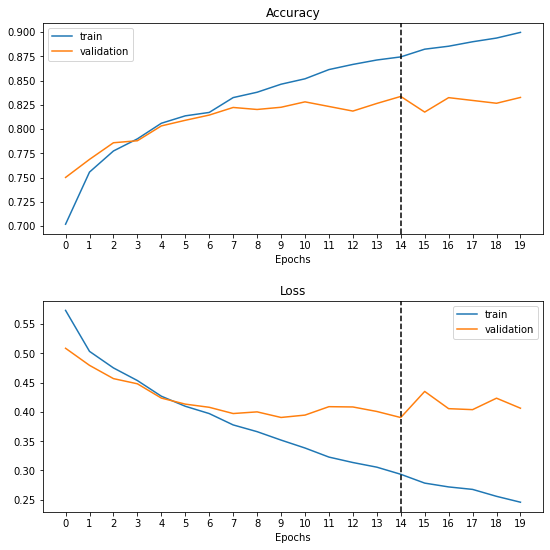

In [96]:
# plot training accuracy
plot_modelfit_process(history, "training process lstm.png")

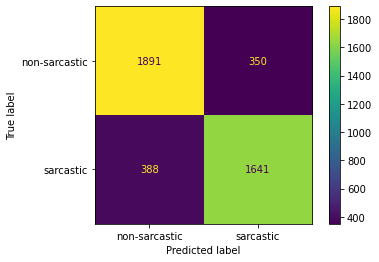

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      2241
           1       0.82      0.81      0.82      2029

    accuracy                           0.83      4270
   macro avg       0.83      0.83      0.83      4270
weighted avg       0.83      0.83      0.83      4270



In [97]:
# show confusion matrix
cm = confusion_matrix(data_test.is_sarcastic, lstm_pred, labels=[0, 1])
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["non-sarcastic", "sarcastic"])
display.plot()
plt.show()
display.im_.figure.savefig(path+"lstm cm.png")

print(classification_report(data_test.is_sarcastic, lstm_pred))

In [72]:
# Bert
# tokenize texts by using pre-trained bert tokenizer
fast_tokenizer = BertWordPieceTokenizer(path+'bert-base-uncased-vocab.txt', lowercase=True)

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=20):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i + chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    return np.array(all_ids)

x_train_encode = fast_encode(data_train.headline, fast_tokenizer, maxlen=20)
x_val_encode = fast_encode(data_val.headline, fast_tokenizer, maxlen=20)
x_test_encode = fast_encode(data_test.headline, fast_tokenizer, maxlen=20)

In [45]:
# build model using pre-trained BERT model
bert_model_pre_trained = TFBertModel.from_pretrained('bert-base-uncased')
bert_input_word_ids = Input(shape=(20,), dtype=tf.int32, name="input_word_ids")
bert_embedding = bert_model_pre_trained(bert_input_word_ids)[0]
cls_token = tf.keras.layers.GlobalAveragePooling1D()(bert_embedding) #bert_embedding[:, 0, :]
bert_output = Dense(1, activation='sigmoid')(cls_token)
bert_model = tf.keras.Model(inputs=bert_input_word_ids, outputs=bert_output)
bert_model.compile(tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss='binary_crossentropy', metrics=['acc'])
bert_model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 20)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             20, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

In [17]:
# train
bert_mc = ModelCheckpoint(path+'best_model_bert1.h5', monitor='val_acc', save_weights_only=True, save_best_only=True, verbose=1)
bert_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

bert_history = bert_model.fit(x_train_encode, data_train.is_sarcastic,
                         batch_size=128,
                         validation_data=(x_val_encode, data_val.is_sarcastic),
                         epochs=10,
                         callbacks=[bert_mc, bert_es])

Epoch 1/10
152/152 [==============================] - ETA: 0s - loss: 0.4923 - acc: 0.7561
Epoch 00001: val_acc improved from -inf to 0.82083, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_bert1.h5
152/152 [==============================] - 179s 1s/step - loss: 0.4923 - acc: 0.7561 - val_loss: 0.3918 - val_acc: 0.8208
Epoch 2/10
152/152 [==============================] - ETA: 0s - loss: 0.3155 - acc: 0.8642
Epoch 00002: val_acc improved from 0.82083 to 0.84274, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_bert1.h5
152/152 [==============================] - 159s 1s/step - loss: 0.3155 - acc: 0.8642 - val_loss: 0.3512 - val_acc: 0.8427
Epoch 3/10
152/152 [==============================] - ETA: 0s - loss: 0.2047 - acc: 0.9195
Epoch 00003: val_acc improved from 0.84274 to 0.84315, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_bert1.h5


In [73]:
# evaluation
bert_model.load_weights(path+'best_model_bert.h5')
bert_model.compile(tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss='binary_crossentropy', metrics=['acc'])
_, test_acc = bert_model.evaluate(x_test_encode, data_test.is_sarcastic, batch_size=128)
print("Accuracy of the model on Testing Data is - ", test_acc * 100)
# 0.85878 - best_model_bert
model_pred_bert = bert_model.predict(x_test_encode, batch_size=128)
bert_pred = np.where(model_pred_bert >= 0.5, 1, 0)

34/34 [==============================] - 11s 171ms/step - loss: 0.4961 - acc: 0.8588
Accuracy of the model on Testing Data is -  85.8782172203064


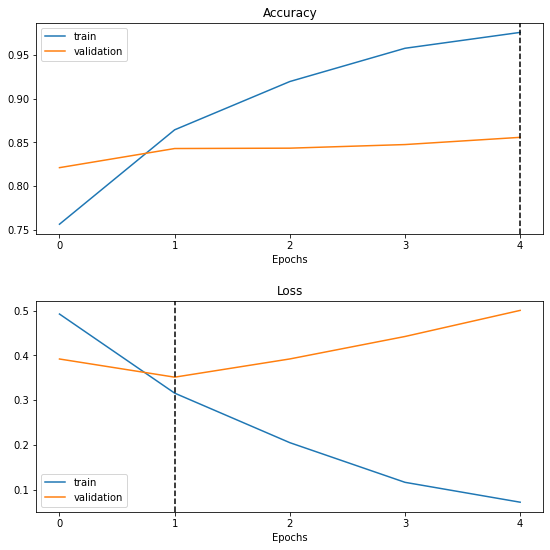

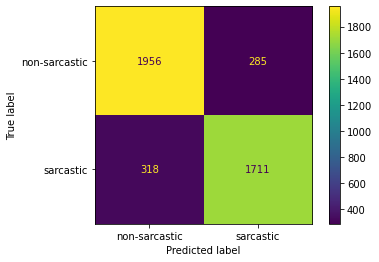

              precision    recall  f1-score   support

           0       0.86      0.87      0.87      2241
           1       0.86      0.84      0.85      2029

    accuracy                           0.86      4270
   macro avg       0.86      0.86      0.86      4270
weighted avg       0.86      0.86      0.86      4270



In [19]:
# plot training accuracy
plot_modelfit_process(bert_history, "training process bert.png")
# show confusion matrix
cm = confusion_matrix(data_test.is_sarcastic, bert_pred, labels=[0, 1])
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["non-sarcastic", "sarcastic"])
display.plot()
plt.show()
display.im_.figure.savefig(path+"bert cm.png")
# classification report
print(classification_report(data_test.is_sarcastic, bert_pred))

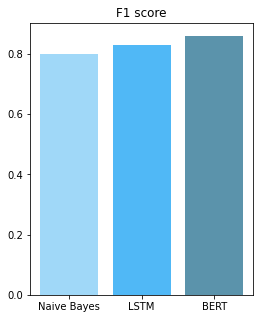

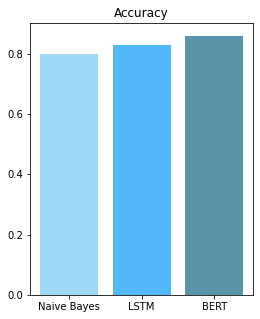

In [32]:
#comparison
nonsar_nb = [0.81,0.81,0.81]
sar_nb = [0.79,0.79,0.79]
f1_nb = 0.80
acc_nb = 0.80

nonsar_lstm = [0.84,0.83,0.83]
sar_lstm = [0.81,0.83,0.82]
f1_lstm = 0.83
acc_lstm = 0.8283372521400452

nonsar_bert = [0.86,0.87,0.87]
sar_bert = [0.86,0.84,0.85]
f1_bert = 0.86
acc_bert = 0.858782172203064

colors = ('#78C8F6','#069AF3','#166688')
labels = ("Naive Bayes", "LSTM", "BERT")

plt.figure(figsize=(4, 5))
plt.bar(range(3), (f1_nb, f1_lstm, f1_bert), tick_label=labels, color=colors, alpha=0.7)
plt.title('F1 score')
plt.savefig(path+'all F1 score.png', dpi=100)
plt.show()

plt.figure(figsize=(4, 5))
plt.bar(range(3), (acc_nb, acc_lstm, acc_bert), tick_label=labels, color=colors, alpha=0.7)
plt.title('Accuracy')
plt.savefig(path+'all Accuracy.png', dpi=100)
plt.show()

In [99]:
# Construct hybrid model from article
# Defining Neural Network
model = Sequential()
# Non-trainable embedding layer
model.add(Embedding(input_dim=size_of_vocabulary, output_dim=200, weights=[embedding_matrix],
                    input_length=20, trainable=False))
# LSTM-CNN
model.add(Bidirectional(LSTM(units=128,
                             return_sequences=True,
                             dropout=0.35)))
model.add(Conv1D(filters=64, kernel_size=3))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
model.add(Dropout(0.35))
model.add(tf.keras.layers.Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy', metrics=['acc'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(path+'best_model_lstm22.h5', monitor='val_acc', mode='max',
                     save_best_only=True, verbose=1)

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 20, 200)           4310400   
                                                                 
 bidirectional_15 (Bidirecti  (None, 20, 256)          336896    
 onal)                                                           
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 64)            49216     
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 9, 64)            0         
 1D)                                                             
                                                                 
 dropout_124 (Dropout)       (None, 9, 64)             0         
                                                                 
 flatten_1 (Flatten)         (None, 576)             

In [100]:
# train
history = model.fit(x_train_seq, data_train.is_sarcastic,
                    batch_size=128,
                    validation_data=(x_val_seq, data_val.is_sarcastic),
                    verbose=1,
                    epochs=20,
                    callbacks=[es,mc])

Epoch 1/20
150/152 [============================>.] - ETA: 0s - loss: 0.5382 - acc: 0.7262
Epoch 00001: val_acc improved from -inf to 0.76131, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_lstm22.h5
152/152 [==============================] - 9s 33ms/step - loss: 0.5379 - acc: 0.7262 - val_loss: 0.4958 - val_acc: 0.7613
Epoch 2/20
151/152 [============================>.] - ETA: 0s - loss: 0.4593 - acc: 0.7811
Epoch 00002: val_acc improved from 0.76131 to 0.78570, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_lstm22.h5
152/152 [==============================] - 3s 21ms/step - loss: 0.4594 - acc: 0.7810 - val_loss: 0.4528 - val_acc: 0.7857
Epoch 3/20
150/152 [============================>.] - ETA: 0s - loss: 0.4264 - acc: 0.8010
Epoch 00003: val_acc improved from 0.78570 to 0.79169, saving model to /content/drive/MyDrive/ColabNotebooks/TextMiningProject/TextMiningData/best_model_lstm22.

In [101]:
# evaluation
#model = load_model(path+'best_model_lstm22.h5')
_, test_acc = model.evaluate(x_test_seq, data_test.is_sarcastic, batch_size=128)
print("Accuracy of the model on Testing Data is - ", test_acc * 100)
model_pred = model.predict(x_test_seq, batch_size=128)
lstm_pred = np.where(model_pred >= 0.5, 1, 0)

34/34 [==============================] - 0s 9ms/step - loss: 0.4653 - acc: 0.8131
Accuracy of the model on Testing Data is -  81.31147623062134


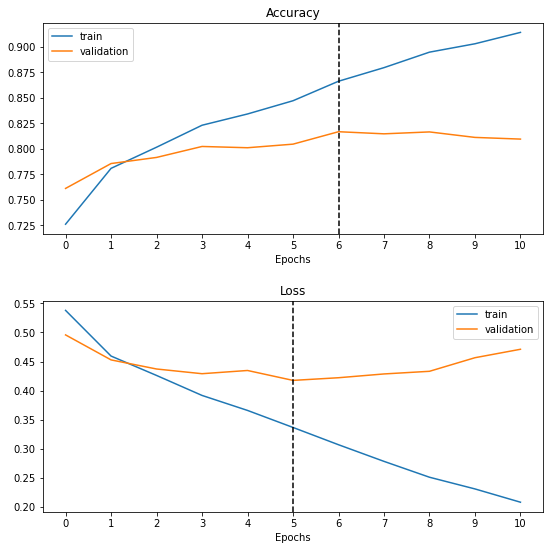

In [102]:
# plot training accuracy
plot_modelfit_process(history, "training process lstm compare.png")

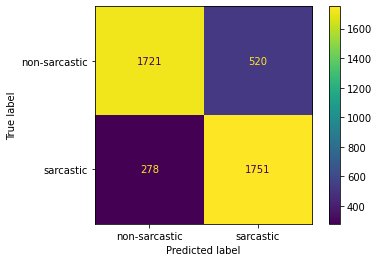

              precision    recall  f1-score   support

           0       0.86      0.77      0.81      2241
           1       0.77      0.86      0.81      2029

    accuracy                           0.81      4270
   macro avg       0.82      0.82      0.81      4270
weighted avg       0.82      0.81      0.81      4270



In [103]:
# show confusion matrix
cm = confusion_matrix(data_test.is_sarcastic, lstm_pred, labels=[0, 1])
display = ConfusionMatrixDisplay(confusion_matrix=cm,
                                 display_labels=["non-sarcastic", "sarcastic"])
display.plot()
plt.show()
display.im_.figure.savefig(path+"lstm cm compare.png")

print(classification_report(data_test.is_sarcastic, lstm_pred))

In [62]:
# analyse come wrongly classified observations
# LSTM model
df_wrong_lstm = data_test[lstm_pred[:,0]!=data_test.is_sarcastic]
#model_pred_lstm

# BERT model
df_wrong_bert = data_test[bert_pred[:,0]!=data_test.is_sarcastic]
#model_pred_bert

# both did wrong
index_wrong = []
for i in df_wrong_bert.index:
  if i in df_wrong_lstm.index:
    index_wrong.append(i)

df_wrong_both = data_test.loc[index_wrong]

In [63]:
df_wrong_both

,headline,is_sarcastic,headline_before
17471,trump motorcade picks lyft passengers help pre...,1,trump motorcade picks up few lyft passengers t...
24836,sports journalist told write slop baseball hea...,1,sports journalist told to write some slop abou...
8815,hillary clinton threatened black man,1,hillary clinton threatened by black man
230,epa accidentally spills millions gallons waste...,0,epa accidentally spills millions of gallons of...
14648,brunch livened jazz trio violent breakup,1,brunch livened up by jazz trio's violent breakup
...,...,...,...
21196,nuclear threat real says muhammad ali,1,"nuclear threat still 'very real,' says muhamma..."
26639,world wonders trump united states forcing nati...,1,world wonders what trump has on united states ...
17309,heartbroken locals hold candlelight vigil taco...,0,heartbroken locals hold candlelight vigil for ...
18177,sci fi geek hangs models,1,sci-fi geek only hangs out with models


In [59]:
df_wrong_lstm

,headline,is_sarcastic,headline_before
5536,reconstruction finally completed field destroy...,1,reconstruction finally completed on field dest...
5389,cannon overshoots tim kaine wells fargo center,1,cannon overshoots tim kaine across wells fargo...
14371,dad loses lose,0,"when dad loses it, we all lose it"
15976,mayor phoenix apologizes naming berlin germany...,1,mayor of phoenix apologizes for naming berlin ...
23948,fda warns company unapproved consumer genetic ...,0,fda warns another company about unapproved con...
...,...,...,...
23602,excited saved bell pop restaurant,0,we're so excited about this 'saved by the bell...
16443,baby fox supposed die finds man believes,0,baby fox who was supposed to die finds man who...
18669,google got plans smart contact lenses,0,google's got plans for 'smart' contact lenses
20143,jeremy piven outraged microsoft word recognize,1,jeremy piven outraged microsoft word doesn't r...


In [58]:
df_wrong_bert

,headline,is_sarcastic,headline_before
5008,christ mao buddha making comeback china,0,"why christ, mao and the buddha are making a co..."
17862,grizzly bear sprained paw mauling hunter repor...,1,grizzly bear sprained paw while mauling hunter...
17281,computer scientists ai underdeveloped ethics l...,1,computer scientists say ai's underdeveloped et...
1826,roadtrip movie character,0,which roadtrip movie character are you?
17471,trump motorcade picks lyft passengers help pre...,1,trump motorcade picks up few lyft passengers t...
...,...,...,...
17309,heartbroken locals hold candlelight vigil taco...,0,heartbroken locals hold candlelight vigil for ...
18177,sci fi geek hangs models,1,sci-fi geek only hangs out with models
27592,freshness escaping bag peas,1,freshness escaping from bag of peas
23602,excited saved bell pop restaurant,0,we're so excited about this 'saved by the bell...
